In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets-4",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2814 files belonging to 4 classes.


2023-05-18 17:21:33.849724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 17:21:33.916341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 17:21:33.916626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 17:21:33.917447: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Splitting the Dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [4]:
total_batches = len(dataset)
train_size = int(0.75 * total_batches)
test_size = int(0.10 * total_batches)
val_size = total_batches - train_size - test_size

print(f"""
    Total Batches: {total_batches},
    Training Batches: {train_size},
    Testing Batches: {test_size},
    Validation Batches: {val_size}
""")

train_ds = dataset.take(train_size) # used for training data
test_ds = dataset.skip(train_size).take(test_size) # final evaluation will be done on this model
val_ds = dataset.skip(train_size + test_size).take(val_size) # used to tune the model


    Total Batches: 88,
    Training Batches: 66,
    Testing Batches: 8,
    Validation Batches: 14



## Cache, Shuffle, and Prefetch the Dataset

In [5]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Image Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Augmentation on Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Designing and Training the Model

In [7]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [8]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the base model's layers so they are not updated during training
base_model.trainable = False

model = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [9]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [10]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (32, 32768)               0         
                                                                 
 dense (Dense)               (32, 256)                 8388864   
                                                                 
 dropout (Dropout)           (32, 256)                 0         
                                                                 
 dense_1 (Dense)             (32, 4)                   1028      
                                                                 
Total params: 23,104,580
Trainable params: 8,389,892
N

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10
)
# Save the best model with the least validation loss
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="finalproject_weights.h5",
    verbose=1,
    save_best_only=True
)

In [12]:
history = model.fit(
    train_ds, 
    epochs = 50,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stopping, checkpointer]
)

Epoch 1/50


2023-05-17 14:52:35.435269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 12 of 2000
2023-05-17 14:52:45.604359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 34 of 2000
2023-05-17 14:52:55.737620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 56 of 2000
2023-05-17 14:53:00.946883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-17 14:53:02.336113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-17 14:53:03.718114: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-17 14:53:03.957345: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that t

 1/66 [..............................] - ETA: 50:54 - loss: 1.7459 - accuracy: 0.2500

2023-05-17 14:53:11.391960: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-17 14:53:11.392017: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


66/66 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7689

2023-05-17 14:54:16.438904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-17 14:54:16.849861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-17 14:54:17.481533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-17 14:54:18.236003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4 of 2000
2023-05-17 14:54:19.545237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-17 14:54:21.755517: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 1: val_loss improved from inf to 0.34554, saving model to finalproject_weights.h5
66/66 [==============================] - 127s 1s/step - loss: 0.6128 - accuracy: 0.7689 - val_loss: 0.3455 - val_accuracy: 0.8789
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.9010
Epoch 2: val_loss improved from 0.34554 to 0.25135, saving model to finalproject_weights.h5
66/66 [==============================] - 31s 477ms/step - loss: 0.2836 - accuracy: 0.9010 - val_loss: 0.2514 - val_accuracy: 0.9193
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9190
Epoch 3: val_loss improved from 0.25135 to 0.24149, saving model to finalproject_weights.h5
66/66 [==============================] - 31s 475ms/step - loss: 0.2357 - accuracy: 0.9190 - val_loss: 0.2415 - val_accuracy: 0.9238
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9422
Epoch 4: val_loss improved from 0.24149 to 0.23043,

## Model Evaluation

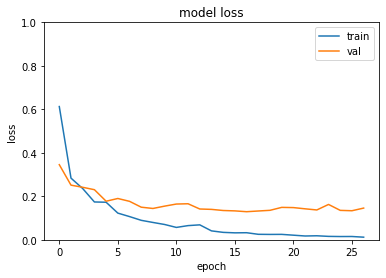

In [13]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

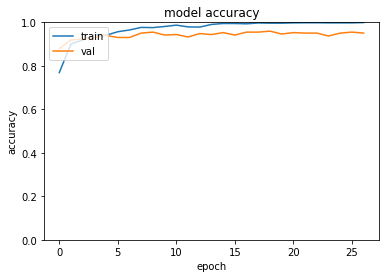

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Save the model architecture
model_json = model.to_json()
with open("finalproject_model.json", "w") as json_file:
    json_file.write(model_json)

## Evaluating the Saved Model Performance

In [13]:
# Load the pretrained model (best saved one)
with open('finalproject_model.json', 'r') as json_file:
    json_saved_model = json_file.read()

# Load the model
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('finalproject_weights.h5')
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=["accuracy"]
)

In [14]:
scores = model.evaluate(test_ds)

2023-05-18 17:22:58.181848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-18 17:22:58.587996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-18 17:22:59.172191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-18 17:23:01.800105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-18 17:23:03.155679: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-18 17:23:04.693698: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-18 17:23:04.929357: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this

1/8 [==>...........................] - ETA: 5:51 - loss: 0.1054 - accuracy: 0.9688

2023-05-18 17:23:12.399264: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-18 17:23:12.399311: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


8/8 [==============================] - 53s 384ms/step - loss: 0.1389 - accuracy: 0.9453


In [15]:
predict = []
y_test = np.array([])
for images, labels in test_ds:
    y_test = np.concatenate((y_test, labels.numpy()), axis=0).astype(int)
    predictions = model.predict(images)
    predict.extend(np.argmax(predictions, axis=1))
predict = np.asarray(predict)

In [16]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9453125


<AxesSubplot:>

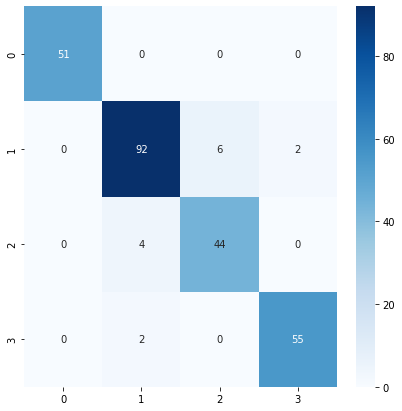

In [17]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

In [18]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       0.94      0.92      0.93       100
           2       0.88      0.92      0.90        48
           3       0.96      0.96      0.96        57

    accuracy                           0.95       256
   macro avg       0.95      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256

